In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

In [4]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # n,3,64,64
            nn.Conv2d(channels_img,features_d,stride=2,padding=1,kernel_size=4),
            nn.LeakyReLU(),
            # n,64,32,32
            self._block(features_d,features_d*2,stride=2,padding=1,kernel_size=4),
            # n,128,16,16
            self._block(features_d*2,features_d*4,stride=2,padding=1,kernel_size=4),
            # n,256,8,8
            self._block(features_d*4,features_d*8,stride=2,padding=1,kernel_size=4),
            # n,512,4,4
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),
            nn.Sigmoid(),
        )
        
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,x):
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self,channels_noise,channels_img,features_g):
        super().__init__()
        self.gen = nn.Sequential(
            # n,channels_noise,1,1
            self._block(channels_noise,features_g*16,kernel_size=4,stride=1,padding=0),
            # n,1024,4,4
            self._block(features_g*16,features_g*8,kernel_size=4,stride=2,padding=1),
            # n,512,8,8
            self._block(features_g*8,features_g*4,kernel_size=4,stride=2,padding=1),
            # n,256,16,16
            self._block(features_g*4,features_g*2,kernel_size=4,stride=2,padding=1),
            # n,128,32,32
            nn.ConvTranspose2d(features_g*2,channels_img,kernel_size=4,stride=2,padding=1),
            nn.Tanh(),
        )
        
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self,x):
        return self.gen(x)

In [7]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
lr = 9e-4
batch_size = 32
num_epochs = 10

disc = Discriminator(1,64).to(device)
gen = Generator(100,1,64).to(device)
initialize_weights(gen)
initialize_weights(disc)
fixed_noise= torch.randn((batch_size,100,1,1)).to(device)

t = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(1)], [0.5 for _ in range(1)]
        ),
    ]
)

dataset = datasets.MNIST(
    root="dataset/", train=True, transform=t, download=True
)

loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
opt_disc = optim.Adam(disc.parameters(),lr=lr)
opt_gen = optim.Adam(gen.parameters(),lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

In [11]:
for epoch in range(30):
    for batch_idx,(real,_) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn(batch_size,100,1,1).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real,torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/10] Batch 0/1875                   Loss D: 0.4912, loss G: 3.6454
Epoch [0/10] Batch 100/1875                   Loss D: 0.2105, loss G: 2.6058
Epoch [0/10] Batch 200/1875                   Loss D: 0.2368, loss G: 4.3124
Epoch [0/10] Batch 300/1875                   Loss D: 0.1431, loss G: 2.4762
Epoch [0/10] Batch 400/1875                   Loss D: 0.4242, loss G: 2.3752
Epoch [0/10] Batch 500/1875                   Loss D: 0.2281, loss G: 5.4656
Epoch [0/10] Batch 600/1875                   Loss D: 0.1011, loss G: 4.0692
Epoch [0/10] Batch 700/1875                   Loss D: 0.8182, loss G: 1.2979
Epoch [0/10] Batch 800/1875                   Loss D: 0.4715, loss G: 3.6141
Epoch [0/10] Batch 900/1875                   Loss D: 0.1893, loss G: 5.2392
Epoch [0/10] Batch 1000/1875                   Loss D: 0.3531, loss G: 3.1632
Epoch [0/10] Batch 1100/1875                   Loss D: 0.1544, loss G: 3.0364
Epoch [0/10] Batch 1200/1875                   Loss D: 0.0764, loss G: 3.288

In [12]:
import matplotlib.pyplot as plt

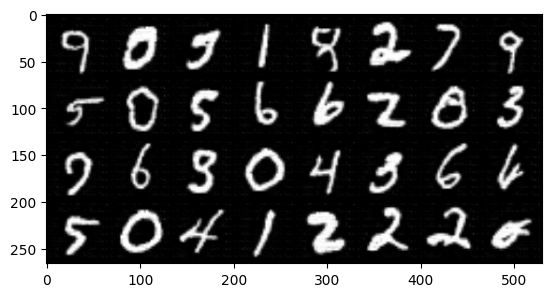

In [19]:
imgs = img_grid_fake.permute(1,2,0)

plt.imshow(imgs.detach().cpu().numpy())